In [15]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [16]:
%matplotlib inline 

In [1]:
import bliss
import torch
import matplotlib.pyplot as plt

In [98]:
# check GPU is configured correctly
device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

5


# Scratch

In [21]:
from astropy.table import Table
t = Table.read("../../../../data/sweep-330m005-340p000.fits")

In [23]:
t['TYPE'][0] == "REX"

True

In [28]:
c = t['TYPE']

In [29]:
c.data

array([b'REX', b'REX', b'REX', ..., b'PSF', b'REX', b'EXP'], dtype='|S3')

In [4]:
r = np.array(t['RA'])
d = np.array(t['DEC'])
mag_r = 22.5 - 2.5 * np.log10(np.array(t['FLUX_R']) )

/tmp/ipykernel_1110080/2737833418.py:3: RuntimeWarning: divide by zero encountered in log10
  mag_r = 22.5 - 2.5 * np.log10(np.array(t['FLUX_R']) )
/tmp/ipykernel_1110080/2737833418.py:3: RuntimeWarning: invalid value encountered in log10
  mag_r = 22.5 - 2.5 * np.log10(np.array(t['FLUX_R']) )


In [5]:
keep = (r > 336.5825) & (r < 336.7461) & (d > -1.044) & (d < -0.8189) & (mag_r < 23.0) & ~np.isnan(mag_r)

In [6]:
cat = t[keep]

In [7]:
cat['BRICKNAME']

<Table length=1216>
RELEASE BRICKID BRICKNAME OBJID  TYPE          RA                 DEC             RA_IVAR          DEC_IVAR           DCHISQ [5]       ... PARALLAX_IVAR    PMRA    PMRA_IVAR     PMDEC     PMDEC_IVAR  MASKBITS FITBITS   SERSIC  SERSIC_IVAR
                                              deg                 deg             1/deg^2          1/deg^2                             ...    1/mas^2     mas / yr 1/(mas/yr)^2  mas / yr  1/(mas/yr)^2                                       
 int16   int32    bytes8  int32 bytes3      float64             float64           float32          float32             float32         ...    float32     float32    float32     float32     float32     int16    int16   float32    float32  
------- ------- --------- ----- ------ ------------------ ------------------- ---------------- ---------------- ---------------------- ... ------------- --------- ------------ ---------- ------------ -------- ------- --------- -----------
   9010  327394  3366m007  3051    PSF 336.58347007788956 -0.8490064674540988   578149940000.0   596254700000.0       16181.864 .. 0.0 ...           0.0       0.0          0.0        0.0          0.0        0       0       0.0         0.0
   9010  327394  3366m007  3059    EXP  336.5836323472919 -0.8235939432111511     6751473000.0     2980243700.0 347.67285 .. 662.61743 ...           0.0       0.0          0.0        0.0          0.0        0    8192       1.0         0.0
    ...     ...       ...   ...    ...                ...                 ...              ...              ...                    ... ...           ...       ...          ...        ...          ...      ...     ...       ...         ...
   9010  325954  3366m010  9293    PSF 336.74567262693705 -1.0214730241310794 27634537000000.0 23169736000000.0        539938.9 .. 0.0 ...     1.9339596 0.8066373    0.9216724 -10.432955    0.6975839        0     128       0.0         0.0
   9010  325954  3366m010  9297    PSF 336.74574567210567 -0.9486427857536832 81835325000000.0 78436280000000.0      19031214.0 .. 0.0 ...     5.2309103  5.652925    1.8562618 -11.330551    1.7344766        0    4224       0.0         0.0
   9010  325954  3366m010  9298    SER  336.7457474686634 -0.9190744103233799  8107154500000.0  5268220000000.0  265875.06 .. 308606.7 ...           0.0       0.0          0.0        0.0          0.0        0       0 2.7549095   595.12213

In [50]:
import torch
objc_type = t["TYPE"].data.astype(str)
is_galaxy = torch.from_numpy(
    (objc_type == "DEV")
    | (objc_type == "REX")
    | (objc_type == "EXP")
    | (objc_type == "SER")
)

In [51]:
is_galaxy

tensor([ True,  True,  True,  ..., False,  True,  True])

# PHOTO 

In [ ]:
from bliss.catalog import PhotoFullCatalog
photo_cat = PhotoFullCatalog.from_file("../../../../data/sdss/", 94, 1, 12, 2)

In [27]:
mags = photo_cat['mags'].reshape(-1)
keep = mags < 17
ra1, dec1 = photo_cat['ra'].reshape(-1)[keep], photo_cat['dec'].reshape(-1)[keep]
np.sort(ra1)

array([336.59192, 336.59354, 336.59888, 336.59955, 336.6004 , 336.60315,
       336.60345, 336.6089 , 336.61496, 336.6205 , 336.6323 , 336.67114,
       336.67117, 336.6725 , 336.67337, 336.67905, 336.68506, 336.68918,
       336.69406, 336.70157, 336.71503, 336.71686, 336.71994, 336.7219 ,
       336.7222 ], dtype=float32)

In [28]:
photo_cat['mags'].min()

tensor(10.3123)

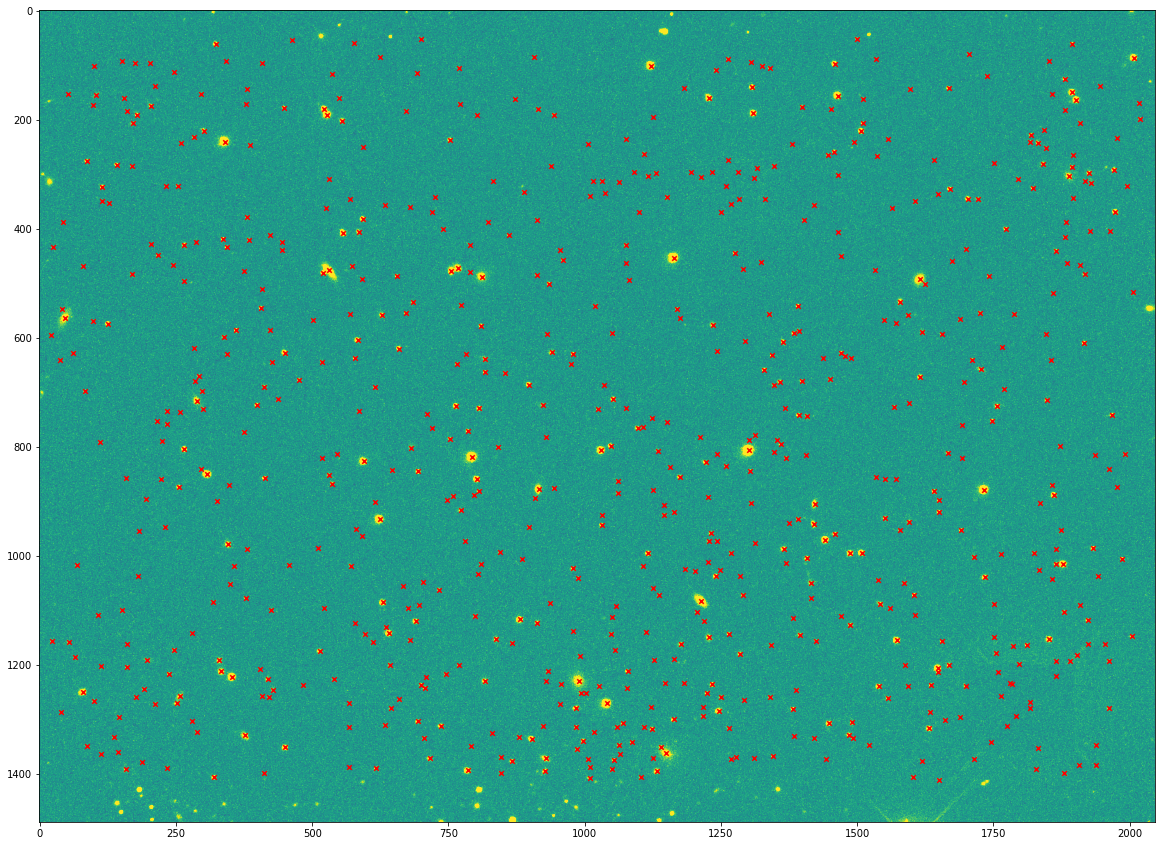

In [16]:
plocs = photo_cat.plocs - 0.5
plt.figure(figsize=(20,20))
plt.imshow(frame.image[0, 0], vmin=700, vmax=1000)
plt.scatter(plocs[0, :, 1].numpy(), plocs[0, :, 0].numpy(), marker='x', color='r', s=21)

# COADD

In [41]:
# load models
from hydra import compose, initialize
from hydra.utils import instantiate
from bliss.encoder import Encoder

with initialize(config_path="../../config"):
    cfg = compose("config", overrides=[])
    
bp = 24
frame = instantiate(cfg.plots.frame, cat_type='coadd')
h_topleft = bp
w_topleft = bp
h_end = ((frame.image.shape[2] - 2 * bp) // 4) * 4 + bp
w_end = ((frame.image.shape[3] - 2 * bp) // 4) * 4 + bp
coadd = frame.get_catalog((h_topleft, h_end), (w_topleft, w_end))
coadd.plocs.shape

torch.Size([1, 889, 2])

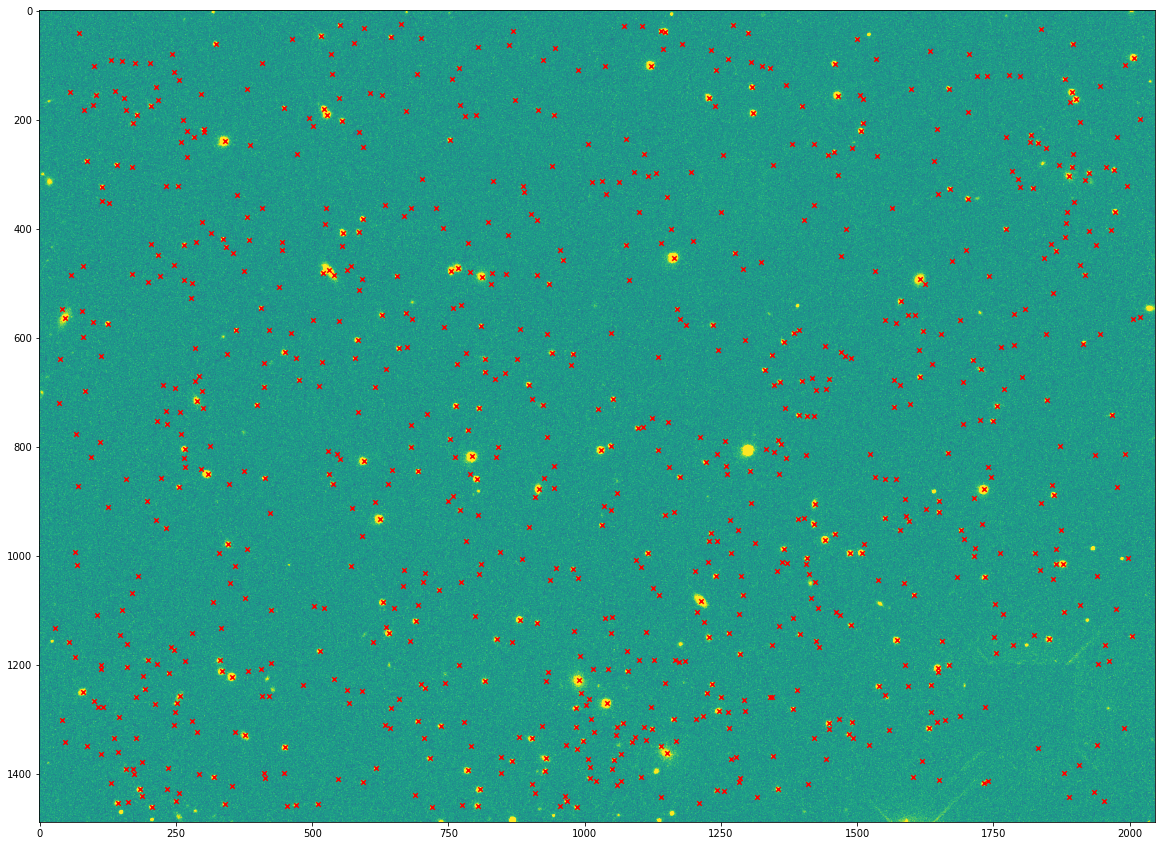

In [49]:
coadd.plocs = coadd.plocs + 24 - 0.5
plt.figure(figsize=(20,20))
plt.imshow(frame.image[0, 0], vmin=700, vmax=1000)
plt.scatter(coadd.plocs[0, :, 1].numpy(), coadd.plocs[0, :, 0].numpy(), marker='x', color='r', s=21)

In [56]:
frame.wcs.all_pix2world(, , 0)

[array([336.58513211, 336.74337761]), array([-1.04154898, -0.82156657])]

# Decals

In [4]:
# load models
from hydra import compose, initialize
from hydra.utils import instantiate
from bliss.encoder import Encoder

with initialize(config_path="../../config"):
    cfg = compose("config", overrides=[])

In [5]:
#ra_lim = (336.5825, 336.7461)
#dec_lim = (-1.044, -0.8189)

bp = 24
frame = instantiate(cfg.plots.frame, cat_type='decals', cat_file="../../../../data/sweep-330m005-340p000.fits")
h_topleft = bp
w_topleft = bp
h_end = ((frame.image.shape[2] - 2 * bp) // 4) * 4 + bp
w_end = ((frame.image.shape[3] - 2 * bp) // 4) * 4 + bp
hlim = (h_topleft, h_end)
wlim = (w_topleft, w_end)

decals_cat = frame.get_catalog(hlim, wlim)
decals = decals_cat.apply_mag_bin(-np.inf, 23)
decals.n_sources

tensor([1139])

In [7]:
plocs = decals.plocs - 0.5
plt.figure(figsize=(20,20))
plt.imshow(frame.image[0, 0], vmin=700, vmax=1000)
plt.scatter(plocs[0, :, 1].numpy(), plocs[0, :, 0].numpy(), marker='x', color='r', s=21)

In [38]:
coad.plocs.shape

torch.Size([1, 730, 2])

In [7]:
torch.sum(decals['galaxy_bools'])

NameError: name 'torch' is not defined

In [ ]:
torch.sum(decals['star_bools'])

In [10]:
decals.plocs[0, :, 0].max(), decals.plocs[0, :, 1].max()

(tensor(1488.6517, dtype=torch.float64),
 tensor(2047.3798, dtype=torch.float64))

In [11]:
decals.height

1488.7145341830978

In [12]:
frame.image.shape

torch.Size([1, 1, 1489, 2048])

## bitwise mask

In [48]:
from astropy.table import Table
t = Table.read("../../../../data/sweep-330m005-340p000.fits")
t = t[10:1000]
b = np.array(t['MASKBITS'])

In [72]:
np.uint?

In [70]:
bin(2048)

'0b100000000000'

In [69]:
bin(0b1110 & 0b100000101)

'0b100'

In [57]:
import

2048

# BLISS

In [96]:
import matplotlib.pyplot as plt
import torch

from bliss.inference import SDSSFrame
from bliss.datasets import sdss
from bliss.inference import reconstruct_scene_at_coordinates
from case_studies.sdss_galaxies.plots.main import load_models


from astropy.table import Table

import plotly.express as px
import plotly.graph_objects as go

In [97]:
# load models
from hydra import compose, initialize
from hydra.utils import instantiate
from bliss.encoder import Encoder

with initialize(config_path="../../config"):
    cfg = compose("config", overrides=[])
    
    
enc, dec = load_models(cfg, device)
bp = enc.border_padding
torch.cuda.empty_cache()

NameError: name 'device' is not defined